In [233]:
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt 
import json
import numpy as np
import pandas as pd
from Metrics import getSentiment, getFactBased

In [234]:
print('Loading File')
file = open('rust-articles-backup.json', encoding='utf8')
articles = pd.DataFrame.from_dict(json.load(file))
print('File Loaded')

Loading File
File Loaded


-1 means that it isn't clustered as a group

In [235]:
X = np.array([[1, 2], [2, 2], [2, 3], [8, 7], [8, 8], [25, 80], [100,100]])
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
clustering.labels_

array([ 0,  0,  0,  1,  1, -1, -1], dtype=int64)

In [236]:
from Clustering import ClusterMetrics

# max_dist works for 0.4-1.1
metrics = np.array(
    [
        [0.9,-0.4], # positive, opinion
        [0.6,-0.3], # positive, opinion
        [0.1,0.7], # neutral, factual
        [-0.2,0.8], # neutral, factual
        [-0.9,-0.8], # negative, opinion
        [-0.6,-0.6], # negative, opinion
    ]
)
labels = ClusterMetrics(metrics)
print(labels)

[0 0 1 1 2 2]


In [237]:
metrics = []
sentiments = []
factBaseds = []
for i in range(1000):
    sentiment = getSentiment(articles.at[i,'body'])
    factBased, _, _ = getFactBased(articles.at[i,'body'])
    
    sentiments.append(sentiment['compound'])
    factBaseds.append(factBased)
    metrics.append([sentiment['compound'], factBased])
print(metrics)

[[-0.3818, 0.02847], [0.0772, -0.66611], [0.972, 1], [-0.9933, -0.18946], [0.9554, -0.44606], [-0.8484, -0.83437], [0.9917, -0.79058], [0.9917, -0.79063], [0.2003, -0.36884], [0.9967, -0.17738], [-0.982, -0.21704], [-0.9246, -0.80055], [-0.3818, -1.0], [0.9369, 0.45026], [0.0, -1.0], [-0.9287, -0.18911], [-0.9904, -0.58848], [-0.9827, -0.85089], [0.9847, -0.72321], [-0.5729, -0.37297], [-0.0498, -0.54802], [0.8122, -1.0], [-0.9937, -0.45024], [-0.9674, -0.44866], [-0.9653, -1.0], [-0.7351, -0.65921], [-0.9766, -0.5048], [-0.8225, -1.0], [-0.9941, -0.57024], [0.9442, -0.25581], [0.9983, -0.61188], [0.9808, -0.66408], [0.9825, -0.27249], [-0.9051, -0.4873], [0.168, -0.40514], [0.997, -0.38521], [-0.0357, 0.1771], [0.9757, -0.17313], [-0.9945, 0.12286], [0.9948, -0.547], [0.2159, -0.04298], [-0.4038, 0.13058], [0.9976, 0.5694], [-0.4109, -0.59824], [-0.9924, -0.66372], [-0.9921, -0.42029], [-0.2496, 0.13045], [0.9895, -0.21722], [-0.9764, -0.35681], [0.8047, -1.0], [0.9973, -0.20457], [0.

Gets best cluster distance

In [238]:
max = 0
maxCounter = 0
counter = 0.01
while counter <= 1:
    labels = ClusterMetrics(np.array(metrics),counter,10)
    length = len(set(labels))
    withGroup = 1 - (np.count_nonzero(labels == -1) / len(labels))
    maximizeValue = withGroup * length
    if maximizeValue > max:
        maxCounter = counter
        max = maximizeValue
    counter = round(counter + 0.01,3)

print(maxCounter,max)

0.15 5.5200000000000005


In [239]:
counter = maxCounter
labels = ClusterMetrics(np.array(metrics),counter,10)
length = len(set(labels))
print(labels)
print(np.count_nonzero(labels == -1))

[-1  4 -1  0  1  0  1  1  3  1  0  0 -1  1  2  0  0  0  1  0  4  1  0  0
  0  0  0  0  0  1  1  1  1  0  3  1 -1  1  0  1 -1 -1  1  0  0  0 -1  1
  0  1  1  1  1  0  3  1  0  0  0  0  0  0  0  0  0  0  1  0  1  1  3  0
  1  1  1  0  1  0  0  1  0  1  1  0  1  0  0  0  0 -1  1  0  1  1 -1  0
  0  0  1  0  1  1  1  1 -1  1  1  0  0  0  0  0  1  1  0  0  1  0  1  0
  0  1  2  0 -1  0  1  1  0  1  0  0  0  0 -1  1  1  1 -1  1  0  0  0  0
  0 -1  1 -1  1  0  1  1  1  1  1  1 -1  1  1  0  0  0  1  0  0  0  4  0
  0  0  0  0  0  1  0  1  1  1  0  1  1  1  1  1  1  1  0  0  0  0  0  1
  0  0  0  0  0  1  0 -1  0  1  0  0  0  0  0  0  0  0  1  0  0  0 -1  1
  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0 -1  0  0  0
  0 -1  0  0  0  1  1  0  0  0  0  1  1  0  0  1  0  0  1  1  0  1  1 -1
  1  4  0 -1  3  0  0  0  0  0  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  0  1  1  1 -1  1  1  1  1 -1  1  0  2  1 -1  0  2  1
  1  1  1  3  1  0  1  0  1  0  0 -1  1  1  1  1  1

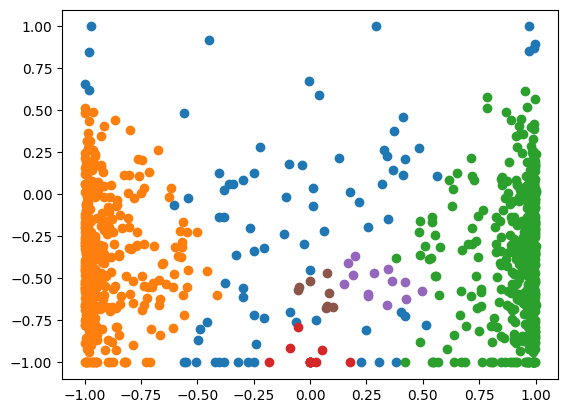

In [240]:
x = [0,1,2]
y = [0,1,1]
for i in range(length):
    i = i - 1
    x = []
    y = []
    for j in range(len(labels)):
        if labels[j] == i:
            x.append(sentiments[j])
            y.append(factBaseds[j])
    plt.scatter(x,y) 
plt.show()